## Ensemble Model Notebook

---

### Objective:

- Given the chosen sampling rate, extraction interval and selected filtered features, to investigate the potential benefit of an ensemble model.

### Methodology:

- Create 2 distinct models:
  - 1 to classify artifacts (label 0), normal (label 2) and abnormal (label 1) (murmur, extrahls, extrastoles)
  - 1 to classify murmur (label 4), extrahls (label 3) and extrastoles (label 5)
- Create a 3rd fusion model to give the final class

#### Findings:

Selected Features after the correlation analysis:


In [1]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix

import sys

sys.path.append("../")
from utils import rebalance_data


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

In [7]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + 'raw/'

# Models
MODELS_DIR = "../../models/"
MODELS_RESULTS = MODELS_DIR + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "filtered"
RESULT_NAME = f"results_models_comparison_best_features_{BALANCING_TYPE}.csv"
CM_ARTIFACT_NAME = f"confusion_matrix_models_comparison_artifact_recognition_{BALANCING_TYPE}.npy"
CM_DISEASE_NAME = (
    f"confusion_matrix_models_comparison_disease_recognition_{BALANCING_TYPE}.npy"
)

In [3]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = f'full_data_{BALANCING_TYPE}_{INTERVAL}s_4000hz_' + '_'.join(numvalue for _, numvalue in num_feats.items()) + '.npy'
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data['train']['X'].shape[1]

In [50]:
print("Class distribution")
print(pd.Series(full_data["train"]["y"]).value_counts())

Class distribution
3.0    1760
0.0     940
2.0     905
4.0     193
1.0     106
Name: count, dtype: int64


### 1st model - Classification of artifacts, normal and abnormal

In [4]:
# prepare the data
old_to_new_labels = {
     0: 0,
     1:1,
     2:1,
     3:2,
     4:1
}

# get the data
X_train = full_data['train']['X']
X_test = full_data['test']['X']

# replace the labels
y_train_newlabel = np.vectorize(old_to_new_labels.get)(full_data['train']['y'])
y_test_newlabel = np.vectorize(old_to_new_labels.get)(full_data['test']['y'])

# Count the number of samples per class
unique, counts = np.unique(y_train_newlabel, return_counts=True)
print("Train class distribution")
print(dict(zip(unique, counts)))

train = np.concatenate((X_train, y_train_newlabel.reshape(-1, 1)), axis=1)
train = np.concatenate((train, y_train_newlabel.reshape(-1, 1)), axis=1)

target_size = int((counts.max() + counts.min()) / 2)

print(f"Target size: {target_size}")
train_balanced = rebalance_data(train, target_size=target_size, random_seed=42)

X_train = train_balanced[:, :-2]
y_train_newlabel = train_balanced[:, -2]

Train class distribution
{0: 940, 1: 1204, 2: 1760}
Target size: 1350



Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP_Ultra
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.840164,0.847283,0.84523
XGBoost,0.841189,0.850371,0.847609
CatBoost,0.856557,0.865993,0.865006
MLP_Ultra,0.873975,0.883704,0.884521


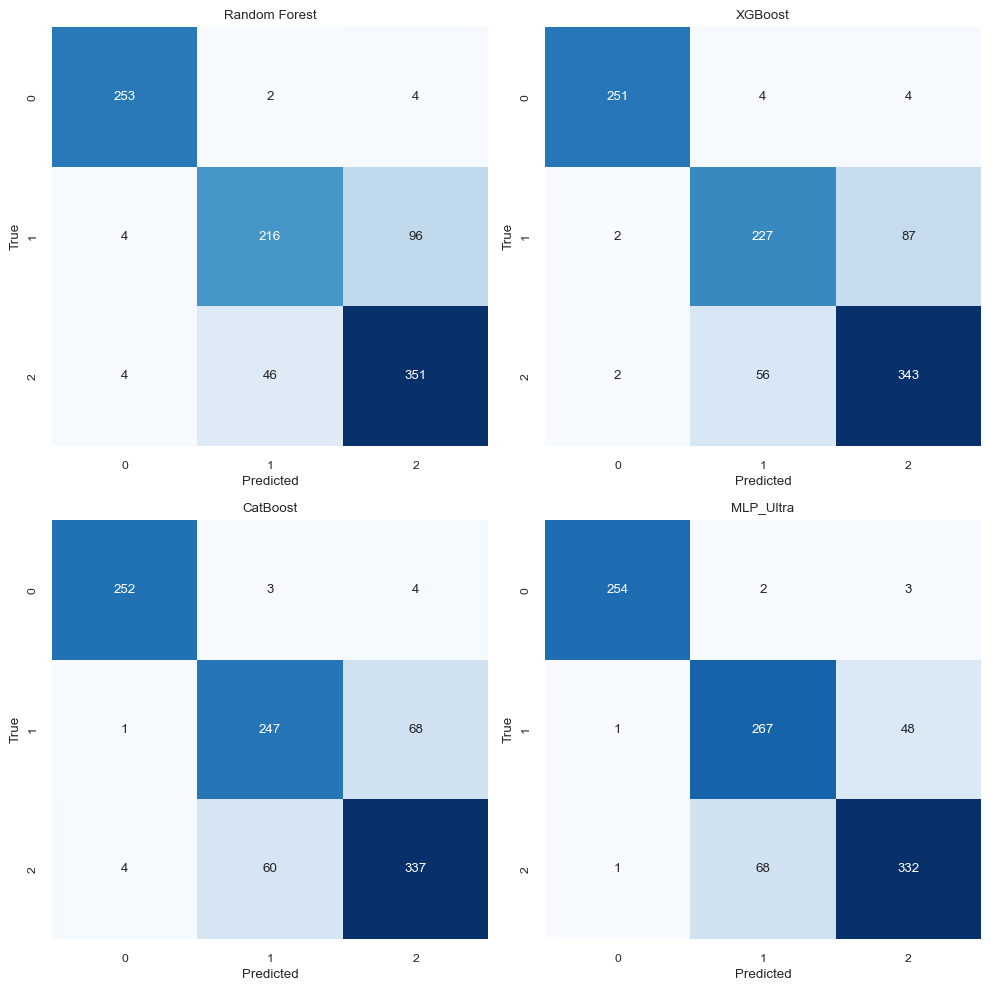

In [52]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
MODELS = {'Random Forest': RandomForestClassifier(random_state=SEED),
        'XGBoost': XGBClassifier(random_state=SEED),
        # 'MLP': MLPClassifier(hidden_layer_sizes=(128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'CatBoost': CatBoostClassifier(random_state=SEED, verbose=0),
        'MLP_Ultra': MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        #'MLP_rollercoaster': MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32), activation='relu', solver='adam', random_state=SEED),

        }

METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")


    # fit the model
    clf.fit(X_train, y_train_newlabel)
    
    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test)

        if "Macro" in metric:
                result_df.loc[model_name, metric] = funct(y_test_newlabel, y_pred, average='macro')
        else:
                result_df.loc[model_name, metric] = funct(y_test_newlabel, y_pred)
        # cf
        cf = confusion_matrix(y_test_newlabel, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_ARTIFACT_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt='d', ax=ax[i//2, i%2], cmap='Blues', cbar=False)
    ax[i//2, i%2].set_title(model_name)
    ax[i//2, i%2].set_xlabel('Predicted')
    ax[i//2, i%2].set_ylabel('True')
plt.tight_layout()
result_df

In [53]:
best_3class_model = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)
best_3class_model.fit(X_train, y_train_newlabel)

MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32), random_state=42)

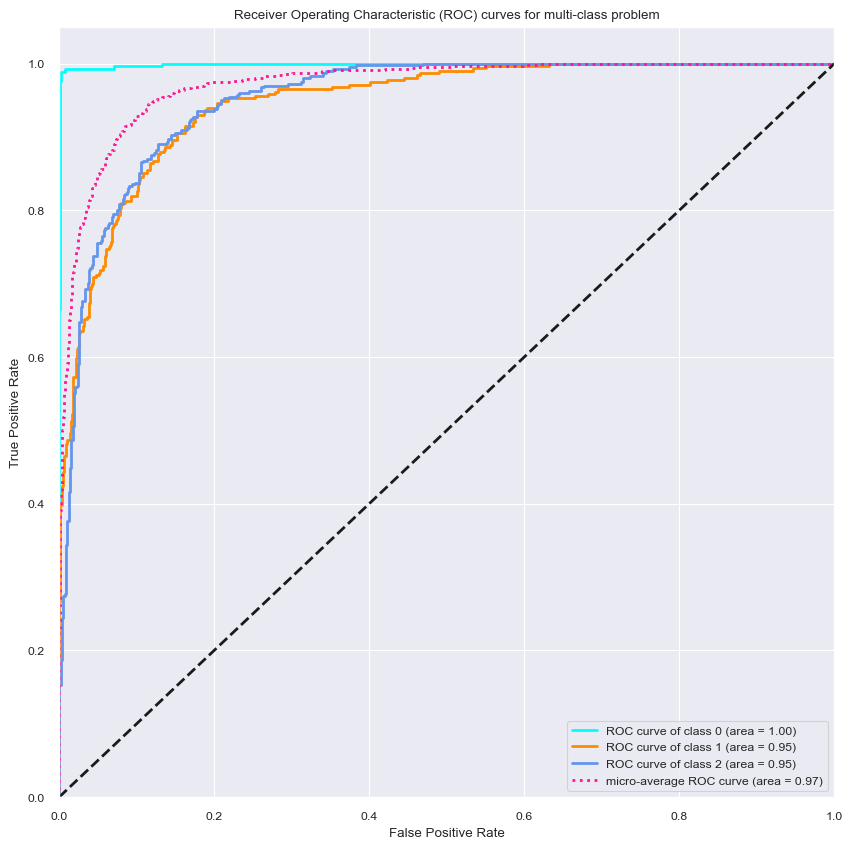

In [54]:
# Predict probabilities for the test set
y_probs = best_3class_model.predict_proba(X_test)

# Binarize the output
y_test_binarized = label_binarize(y_test_newlabel, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})" "".format(i, roc_auc[i]),
    )

plt.plot(
    fpr["micro"],
    tpr["micro"],
    color="deeppink",
    linestyle=":",
    linewidth=2,
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) curves for multi-class problem")
plt.legend(loc="lower right")
plt.show()



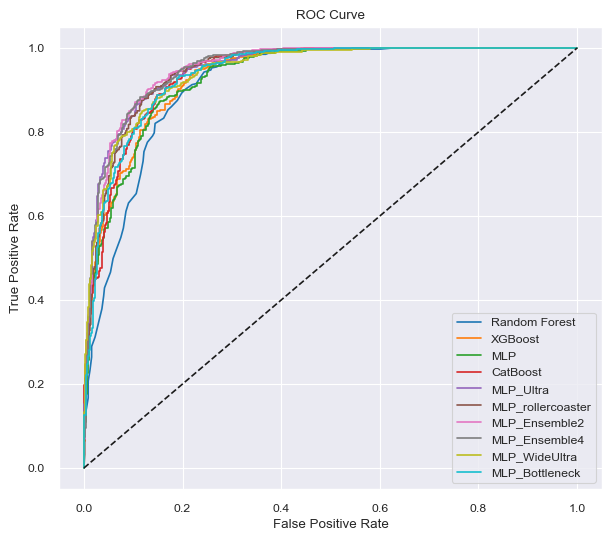

In [8]:
from sklearn.ensemble import VotingClassifier
import joblib


MODELS = {'Random Forest': RandomForestClassifier(random_state=SEED),
        'XGBoost': XGBClassifier(random_state=SEED),
        'MLP': MLPClassifier(hidden_layer_sizes=(128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'CatBoost': CatBoostClassifier(random_state=SEED, verbose=0),
        'MLP_Ultra': MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'MLP_rollercoaster': MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32), activation='relu', solver='adam', random_state=SEED),
        "MLP_Ensemble2": VotingClassifier(
        estimators=[
            ("RandomForest", RandomForestClassifier(random_state=SEED)),
            ("MLP_Ultra", MLPClassifier( hidden_layer_sizes=(512,256,128,64,32,),activation="relu",solver="adam",random_state=SEED,),),],voting="soft",),
        "MLP_Ensemble4": VotingClassifier(
        estimators=[
            (
                "MLP_Rollercoaster",
                MLPClassifier(
                    hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Large",
                MLPClassifier(
                    hidden_layer_sizes=(
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
            (
                "MLP_Ultra",
                MLPClassifier(
                    hidden_layer_sizes=(
                        512,
                        256,
                        128,
                        64,
                        32,
                    ),
                    activation="relu",
                    solver="adam",
                    random_state=SEED,
                ),
            ),
        ],
        voting="soft",
    ),
         "MLP_WideUltra": MLPClassifier(
        hidden_layer_sizes=(1024, 1024, 128, 32),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
         "MLP_Bottleneck": MLPClassifier(
        hidden_layer_sizes=(
            512,
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
}

y_test_binarized = label_binarize(y_test_newlabel, classes=[0, 1, 2])
ACCEPTED_ERRORS = [0.01, 0.05, 0.1, 0.2]

for ACCEPTED_ERROR in ACCEPTED_ERRORS:
    # Initialize dictionaries to store metrics
    fpr = dict()
    tpr = dict()
    f1 = dict()
    balanced_accuracy = dict()

    # Loop through each model, fit it, and calculate metrics
    for model_name, model in MODELS.items():
        
        
        # load the model with joblib if present
        try:
            model = joblib.load(MODELS_DIR + f'{model_name}_FPR.joblib')
        except:
            model.fit(X_train, y_train_newlabel)
            # save the model with joblib
            joblib.dump(model, MODELS_DIR + f'{model_name}_FPR.joblib')
            
        y_probs = model.predict_proba(X_test)
        
        fpr[model_name] = dict()
        tpr[model_name] = dict()
        f1[model_name] = dict()
        balanced_accuracy[model_name] = dict()
        
        # for i in range(3):
        #     fpr[model_name][i], tpr[model_name][i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
        
        f1[model_name]['macro'] = f1_score(y_test_newlabel, np.argmax(y_probs, axis=1), average='macro')
        balanced_accuracy[model_name]['macro'] = balanced_accuracy_score(y_test_newlabel, np.argmax(y_probs, axis=1))
        
        fpr[model_name]['micro'], tpr[model_name]['micro'], _ = roc_curve(y_test_binarized[:,2].ravel(), y_probs[:,2].ravel())
        f1[model_name]['micro'] = f1_score(y_test_newlabel, np.argmax(y_probs, axis=1), average='macro')
        balanced_accuracy[model_name]['micro'] = balanced_accuracy_score(y_test_newlabel, np.argmax(y_probs, axis=1))

    # Create a DataFrame to store the results
    results = []
    for model_name in MODELS.keys():
        results.append({
            'Model': model_name,
            'F1 (Macro)': f1[model_name]['macro'],
            'Balanced Accuracy (Macro)': balanced_accuracy[model_name]['macro'],
            # take the min FPR and related TPR
            'FPR': fpr[model_name]['micro'][np.argmin(np.abs(fpr[model_name]['micro'] - ACCEPTED_ERROR))],
            'TPR': tpr[model_name]['micro'][np.argmin(np.abs(fpr[model_name]['micro'] - ACCEPTED_ERROR))],
            
        })

    roc_df = pd.DataFrame(results)
    roc_df.to_csv(MODELS_RESULTS + f'roc_results_{ACCEPTED_ERROR}.csv')

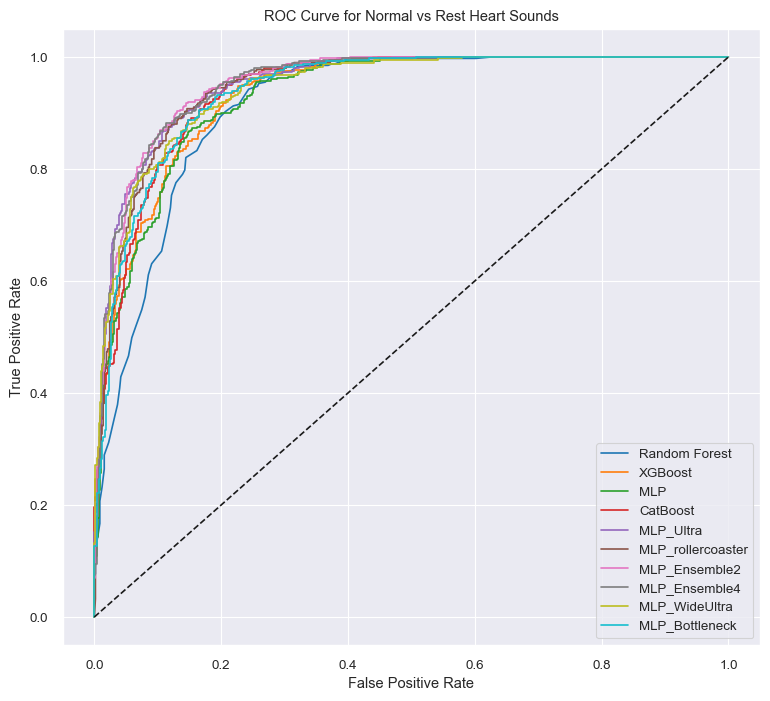

In [24]:
# Use a seaborn color palette
sns.set_theme("paper", font_scale=1.1)
palette = sns.color_palette("tab10", len(MODELS.keys()))  # color palette with 4 different colors
# Plot fpr, tpr and f1 score
plt.figure(figsize=(9,8))
for i, model_name in enumerate(MODELS.keys()):
    plt.plot(fpr[model_name]['micro'], tpr[model_name]['micro'], label=model_name, color=palette[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Normal vs Rest Heart Sounds')
plt.legend()

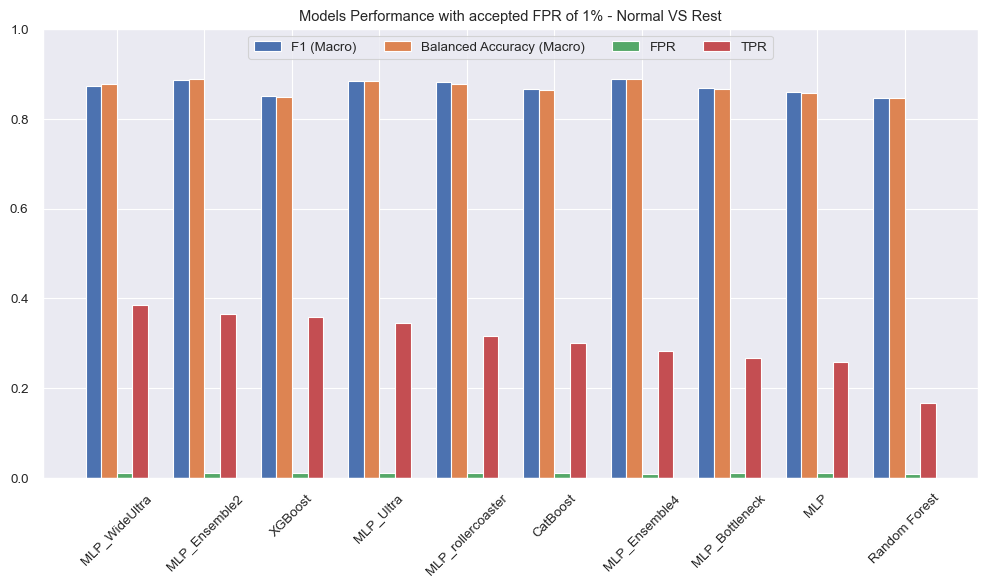

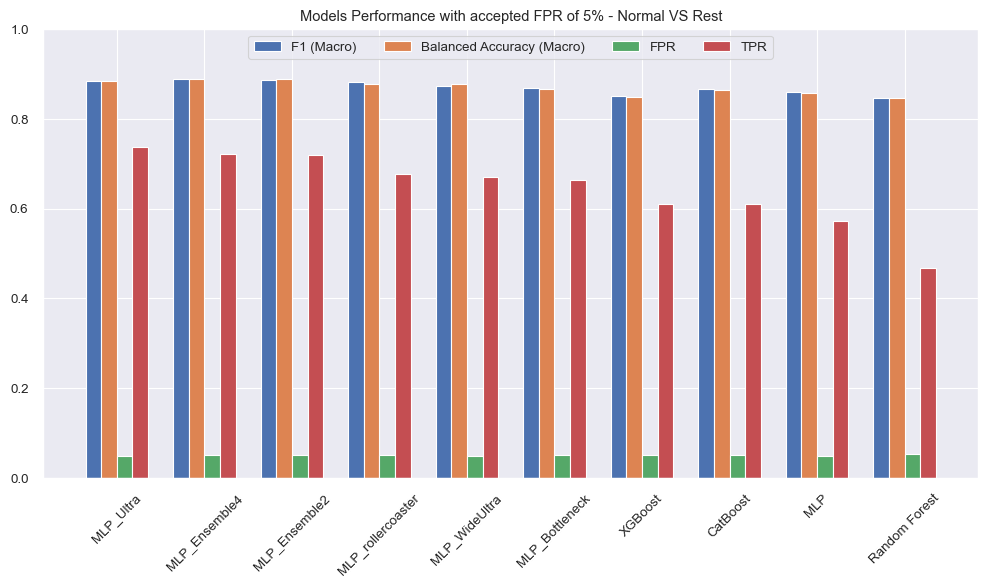

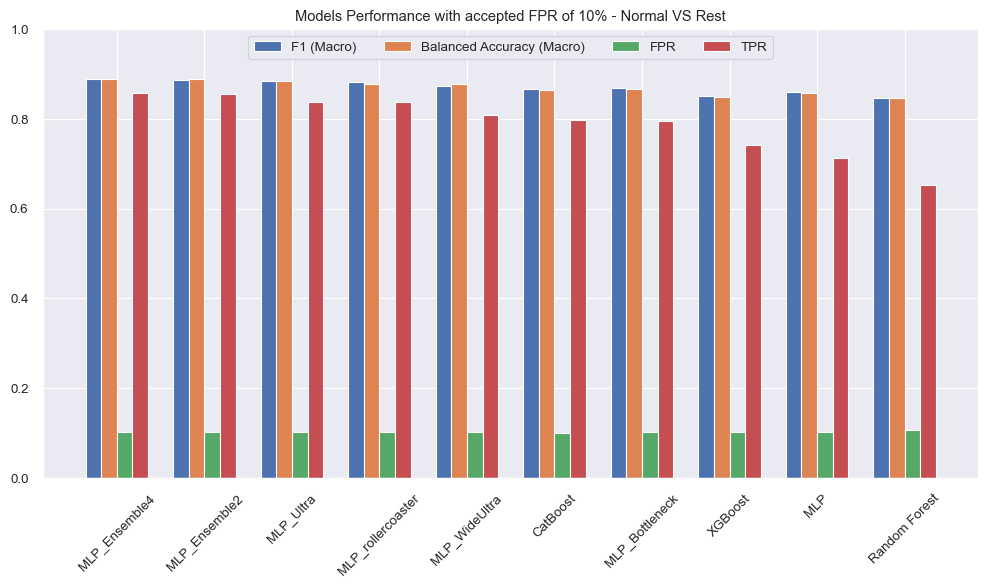

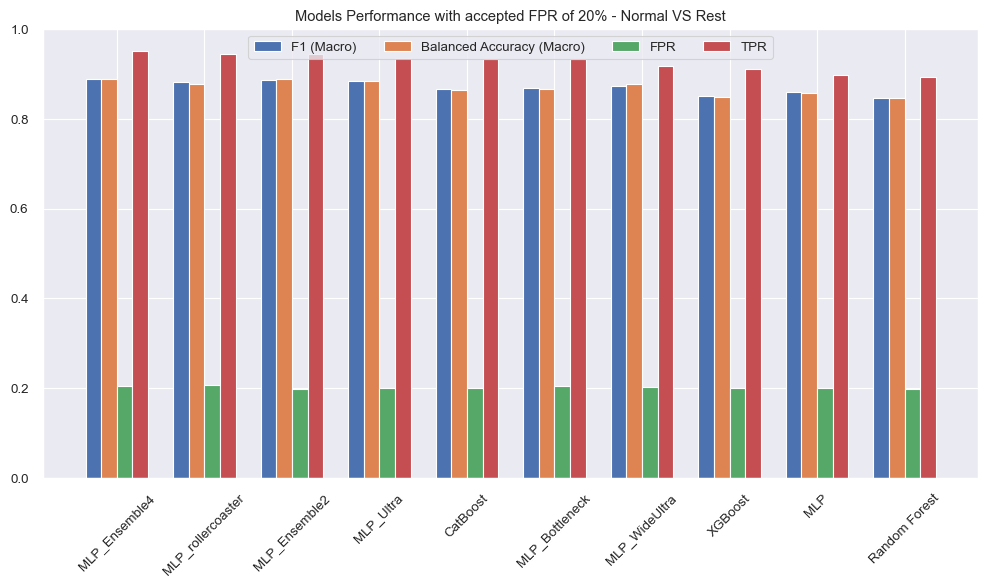

In [25]:
# Use a seaborn color palette
palette = sns.color_palette("deep", 4)  # color palette with 4 different colors
sns.set_theme("paper", font_scale=1.1)

# LOAD THE DATA
for ACCEPTED_ERROR in ACCEPTED_ERRORS:
    # LOAD THE DATA
    roc_df = pd.read_csv(MODELS_RESULTS + f'roc_results_{ACCEPTED_ERROR}.csv')
    

    # Plotting
    plt.figure(figsize=(10, 6))
    n_models = len(MODELS)
    bar_width = 0.25
    space_between_groups = 0.4  # Space between groups of bars
    # Calculate positions with space between groups of bars
    bar_positions = np.arange(n_models) * (4 * bar_width + space_between_groups)
    metrics = ['F1 (Macro)', 'Balanced Accuracy (Macro)', 'FPR', 'TPR']

    # sort by decreasing value of TPR
    roc_df = roc_df.sort_values('TPR', ascending=False)

    # Plot bars for each metric
    for i, metric in enumerate(metrics):
        metric_positions = bar_positions + i * bar_width
        plt.bar(metric_positions, roc_df[metric], width=bar_width, color=palette[i], label=metric)
    plt.ylim(0, 1)
    plt.xticks(bar_positions + 1.5 * bar_width, roc_df['Model'], rotation=45)
    plt.legend(loc='upper center', ncol=4)
    plt.title(f'Models Performance with accepted FPR of {int(ACCEPTED_ERROR*100)}% - Normal VS Rest')
    plt.tight_layout()
    plt.show()


## 2nd model - Heart disease prediction model (predicts the diseases only)

In [55]:
# prepare the data
old_to_new_labels = {
     1:0,
     2:1,
     4:2
}

# get the data
X_train = full_data['train']['X']
X_test = full_data['test']['X']
y_train = full_data['train']['y']
y_test = full_data['test']['y']

# remove class 0 and 3
train_mask = np.isin(y_train, [1, 2, 4])
test_mask = np.isin(y_test, [1, 2, 4])

X_train_disease = X_train[train_mask]
X_test_disease = X_test[test_mask]
y_train_disease = np.vectorize(old_to_new_labels.get)(y_train[train_mask])
y_test_disease = np.vectorize(old_to_new_labels.get)(y_test[test_mask])

# Count the number of samples per class
unique, counts = np.unique(y_train_disease, return_counts=True)
print("Train class distribution")
print(dict(zip(unique, counts)))

train = np.concatenate((X_train_disease, y_train_disease.reshape(-1, 1)), axis=1)
train = np.concatenate((train, y_train_disease.reshape(-1, 1)), axis=1)

target_size = int((counts.max() + counts.min()) / 2)

print(f"Target size: {target_size}")
train_balanced = rebalance_data(train, target_size=target_size, random_seed=42)

X_train_disease = train_balanced[:, :-2]
y_train_disease = train_balanced[:, -2]

Train class distribution
{0: 106, 1: 905, 2: 193}
Target size: 505



Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP_Ultra
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.844937,0.790271,0.817699
XGBoost,0.873418,0.83357,0.860909
CatBoost,0.879747,0.837357,0.87118
MLP_Ultra,0.892405,0.859507,0.878719


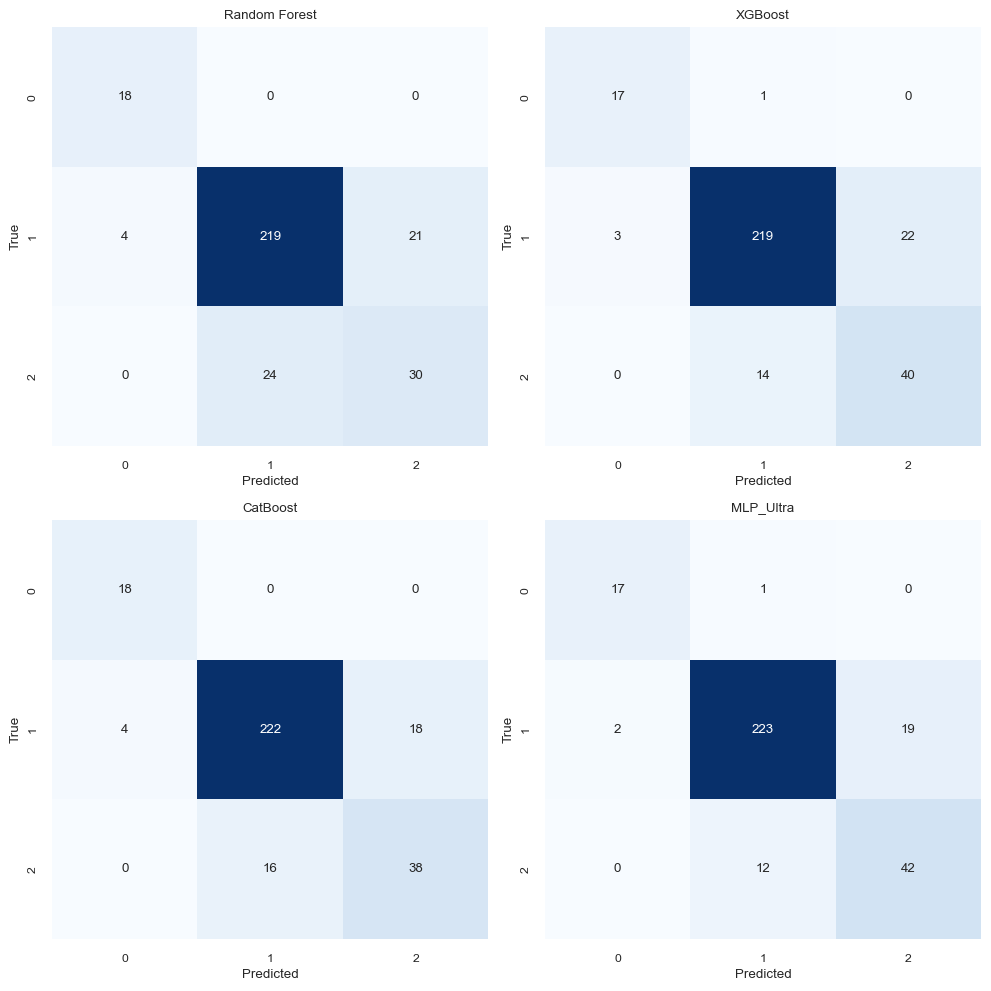

In [56]:
# df to store the results
result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # fit the model
    clf.fit(X_train_disease, y_train_disease)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test_disease)

        if "Macro" in metric:
            result_df.loc[model_name, metric] = funct(y_test_disease, y_pred, average="macro")
        else:
            result_df.loc[model_name, metric] = funct(y_test_disease, y_pred)
        # cf
        cf = confusion_matrix(y_test_disease, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_DISEASE_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt='d', ax=ax[i//2, i%2], cmap='Blues', cbar=False)
    ax[i//2, i%2].set_title(model_name)
    ax[i//2, i%2].set_xlabel('Predicted')
    ax[i//2, i%2].set_ylabel('True')
plt.tight_layout()

result_df

In [57]:
best_disease_model = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32,), activation='relu', solver='adam', random_state=SEED)
best_disease_model.fit(X_train_disease, y_train_disease)

MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32), random_state=42)

## SOluzione Semplice

In [58]:
def predict(class_model, disease_model, X):
    # Predict 3classes (0 for artifact, 1 for abnormal, 2 for normal)
    artifact_pred = class_model.predict(X).reshape(-1,)

    # Predict disease (assuming output is an integer class label 0, 1, 2 for diseases)
    disease_pred = disease_model.predict(X)

    # Ensure disease predictions are reshaped to match artifact predictions
    disease_pred = disease_pred.reshape(-1,)

    # Add 1 to disease predictions to differentiate disease classes from other classes
    y_pred = disease_pred + 3

    # Multiply by artifact predictions to set disease predictions to 0 for artifacts
    y_pred = y_pred * artifact_pred
    
    # reset labels to match the actual labels
    new_to_old_labels = {
        0: 0,
        3: 1,
        2: 3,
        4: 2,
        5: 4,
        6: 3,
        8: 3,
        10: 3,
    }
    y_pred = np.vectorize(new_to_old_labels.get)(y_pred)

    print(f"artifact_pred shape: {artifact_pred.shape}")
    print(f"disease_pred shape: {disease_pred.shape}")
    print(f"y_pred shape: {y_pred.shape}")

    return y_pred


# Extract data from the dictionary
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

y_pred = predict(best_3class_model, best_disease_model, X_test)

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")

artifact_pred shape: (976,)
disease_pred shape: (976,)
y_pred shape: (976,)
F1 Score: 0.77211538542291
Accuracy Score: 0.8483606557377049
Balanced Accuracy Score: 0.7906867796855941


## Uso un terzo modello per predire

F1 Score: 0.77211538542291
Accuracy Score: 0.8483606557377049
Balanced Accuracy Score: 0.7906867796855941


Text(0.5, 1.0, 'Confusion Matrix')

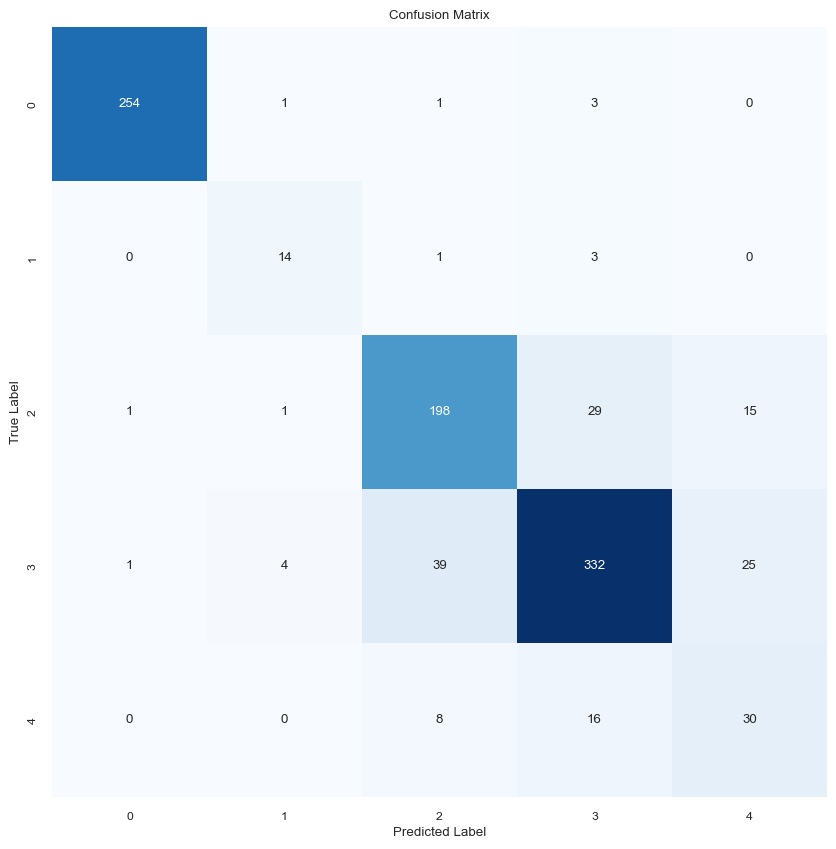

In [59]:
# Extract data from the dictionary
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]


# Predictions for training data
pred_3class_train = best_3class_model.predict(X_train)
pred_disease_train = best_disease_model.predict(X_train)
pred_3class_test = best_3class_model.predict(X_test)
pred_disease_test = best_disease_model.predict(X_test)

# Concatenate predictions to form new feature set
X_train_new = np.concatenate(
    (pred_3class_train.reshape(-1, 1), pred_disease_train.reshape(-1, 1)), axis=1
)

X_test_new = np.concatenate(
    (pred_3class_test.reshape(-1, 1), pred_disease_test.reshape(-1, 1)), axis=1
)

# Train the final model
last_model = CatBoostClassifier(random_state=SEED, verbose=0)
last_model.fit(X_train_new, y_train)

# Predict using the final model
y_pred = last_model.predict(X_test_new)

# Calculate and print metrics
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")

# plot the confusion matrix
cf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")